# Final Project: Overview

# Objective

The objective of this project is for you to demonstrate your mastery of the Machine Learning process
**using Neural Networks**.



# Submission requirements

The guidelines will be similar to the Midterm
- you will write a procedure that takes raw data and produces predictions

You will submit a *single* model for evaluation.

**Demonstrate that all cells in your notebook work**

The final cell in your notebook should print the message "Done"
- `print("Done")`
- If we run your notebook and this last cell does not execute your submission will be inadequate

## Testing

*You must perform out of sample testing*.

If you want to perform cross-validation in training, that is fine, but you
must *also* test out of sample to show that you are not over-fitting.

It is up to you to create the out of sample data that you feel best evaluates your model.

We will create holdout data (that we will not show you) for grading.

The procedure you write to make predictions should be able to work on the unseen holdout data
(similar to how it should work for your test set but the holdout set has *no targets*)

    

# The data

Data will be provided to you 
- as multiple files in a directory which we refer to as a *data directory*

The reason for this is that the different files may convey different information.

You will be responsible for deciding
- which files to use
- which fields within the files to use

We will give you a data directory for training.

# Submission guidelines

Here are the basics, a code template that you must complete is in the following cells
- you will be required to store  your model in a file
- you will be required to write a procedure `MyModel` that takes two arguments
    - `test_dir`
        - this is a *relative path* to the holdout data directory
    - `model_save_file`
        - this is a *relative path* to the file containing your model
- the holdout data directory is similar in structure to the training data directory
    - but without target labels !  It is your job to predict these.
- your procedure must produce predictions given this holdout data directory

This means that your procedure must
- prepare the files in the holdout data directory similar to the way that they were prepared in the training data directory

We will provide you with a sample data directory that will resemble the holdout -- this is so that you
may test the procedure you write for submission.



## Detailed submission guidelines


In **addition to your notebook that trains/evaluates your model**, 
- please also submit the file that contains your trained model.
    - use `saveModel` to put your final, trained model in this file
- We will **not** train your model; we will only use the method `MyModel`
    - which **you** will implement
    - and which uses `loadModel` and the name of the file in which the model was saved
    - this will create the model that we will evaluate


Here is a code template for you to complete
- it will save your model (assuming it is in variable `my_model`)
- it provides the specification for procedure `MyModel`, which *you must complete*


In [2]:
# import os
# from tensorflow.keras.models import load_model

# modelName = "final_model"
# model_path = os.path.join(".", modelName)

# def saveModel(model, model_path): 
#     """
#     Save a model
    
#     Parameters
#     ----------
#     model: a Keras model object
#     model_path: String.  Relative path to a file in which the model will be stored
    
    
#     Returns
#     -------
#     model_save_file: String.  Name of the file in which the model has been saved
#         - this will be model_path with the proper file-extension added
#     """
    
#     model_save_file = model_path + '.keras'
      
#     model.save(model_save_file)
    
#     print(f"Model saved in {model_save_file:s}; submit with your assignment.")
    
#     return model_save_file
   
# def loadModel(model_save_file):
#     model = tf.keras.models.load_model( model_save_file )
  
#     return model

# def MyModel(test_dir, model_save_file):
#     # YOU MAY NOT change model after this statement !
#     model = loadModel(model_save_file)
    
#     # It should run model to create an array of predictions; we initialize it to the empty array for convenience
#     predictions = []
    
#     # We need to match your array of predictions with the examples you are predicting
#     # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
#     # For Bankruptcy: the Id column
#     # For Stock prediction: the date on which you are making a prediction
#     ids = []
    
#     # YOUR CODE GOES HERE
    
    
#     return predictions, ids

# # Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
# my_model = None # CHANGE None to your model !

# model_save_file = saveModel(my_model, model_path)

## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will restore your model from the saved file`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [3]:
# holdout_dir = os.path.join(".", "Data", "holdout")
# predicts = MyModel(holdout_dir, model_save_file)

In [4]:
print("Done")

Done


For this project, I’m treating the task as a regression problem. I think it is more appropriate because it actually includes the information from classification (positive or negative return). Predicting the return size (not just the direction) could also be more useful later if needed for error calculation.

I'll start by working only with AAPL data and basic features like past returns and moving averages to build a simple model first. Once that's working, I’ll add more features, maybe from other tickers too, and try different architectures to improve it.

In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, Input, Conv1D, Attention, LayerNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb

print("Running TensorFlow version ",tf.__version__)
version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.19.0
Version 2, minor 19


I will start some exploratory data analysis (I first started without the function but then I realized I may need it for other tickers than AAPL as well)

In [76]:
def explore_ticker(data_dir, ticker):
    """
    Load and perform basic exploratory data analysis for a given ticker,
    and plot everything nicely in subplots.
    
    Args:
    - data_dir: str, path to the directory containing CSV files
    - ticker: str, the ticker symbol (e.g., "AAPL")
    
    Returns:
    - df: pandas DataFrame of the loaded ticker data
    """
    # Load the data
    file_path = os.path.join(data_dir, f"{ticker}.csv")
    df = pd.read_csv(file_path, parse_dates=["Dt"])
    df.set_index("Dt", inplace=True)
    
    # Show basic head
    print(f"\n--- {ticker} Head ---")
    print(df.head())
    
    # Compute additional columns
    df['Return'] = df['Adj Close'].pct_change()
    df['Cumulative_Return'] = (1 + df['Return']).cumprod() - 1

    # Set up the figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"{ticker} Exploratory Data Analysis", fontsize=16)

    # Plot Adj Close
    axes[0, 0].plot(df['Adj Close'])
    axes[0, 0].set_title("Adjusted Close Price")
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("Price")
    axes[0, 0].grid(True)

    # Plot Daily Returns
    axes[0, 1].plot(df['Return'])
    axes[0, 1].set_title("Daily Returns")
    axes[0, 1].set_xlabel("Date")
    axes[0, 1].set_ylabel("Return")
    axes[0, 1].grid(True)

    # Plot Cumulative Returns
    axes[1, 0].plot(df['Cumulative_Return'])
    axes[1, 0].set_title("Cumulative Returns")
    axes[1, 0].set_xlabel("Date")
    axes[1, 0].set_ylabel("Cumulative Return")
    axes[1, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    axes[1, 0].grid(True)

    # Plot Volume
    axes[1, 1].plot(df['Volume'])
    axes[1, 1].set_title("Trading Volume")
    axes[1, 1].set_xlabel("Date")
    axes[1, 1].set_ylabel("Volume")
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()

    # Return statistics
    print(f"\n--- {ticker} Return Statistics ---")
    print(df['Return'].describe())
    
    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Date range
    print("\nDate range:")
    print(f"Start date: {df.index.min()}")
    print(f"End date: {df.index.max()}")
    
    # Data types
    print("\nData types:")
    print(df.dtypes)
    
    # Basic statistics
    print("\nBasic statistics:")
    print(df.describe())
    
    # Total rows
    print("\nTotal number of rows:", len(df))
    
    # Random sample
    print("\nRandom sample of data:")
    print(df.sample(5, random_state=42))
    
    return df

I am taking adjusted close prices to account for multiple stock splits AAPL had durng the testing period.


--- AAPL Head ---
            Adj Close    Close  Div  Factor     High      Low      Open  \
Dt                                                                        
2000-01-03     3.4785  111.938  0.0     1.0  112.500  101.688  104.8750   
2000-01-04     3.1852  102.500  0.0     1.0  110.625  101.188  108.2500   
2000-01-05     3.2318  104.000  0.0     1.0  110.563  103.000  103.7500   
2000-01-06     2.9521   95.000  0.0     1.0  107.000   95.000  106.1183   
2000-01-07     3.0920   99.500  0.0     1.0  101.000   95.500   96.5000   

                 Volume  
Dt                       
2000-01-03  133949200.0  
2000-01-04  128094400.0  
2000-01-05  194580400.0  
2000-01-06  191993200.0  
2000-01-07  115183600.0  


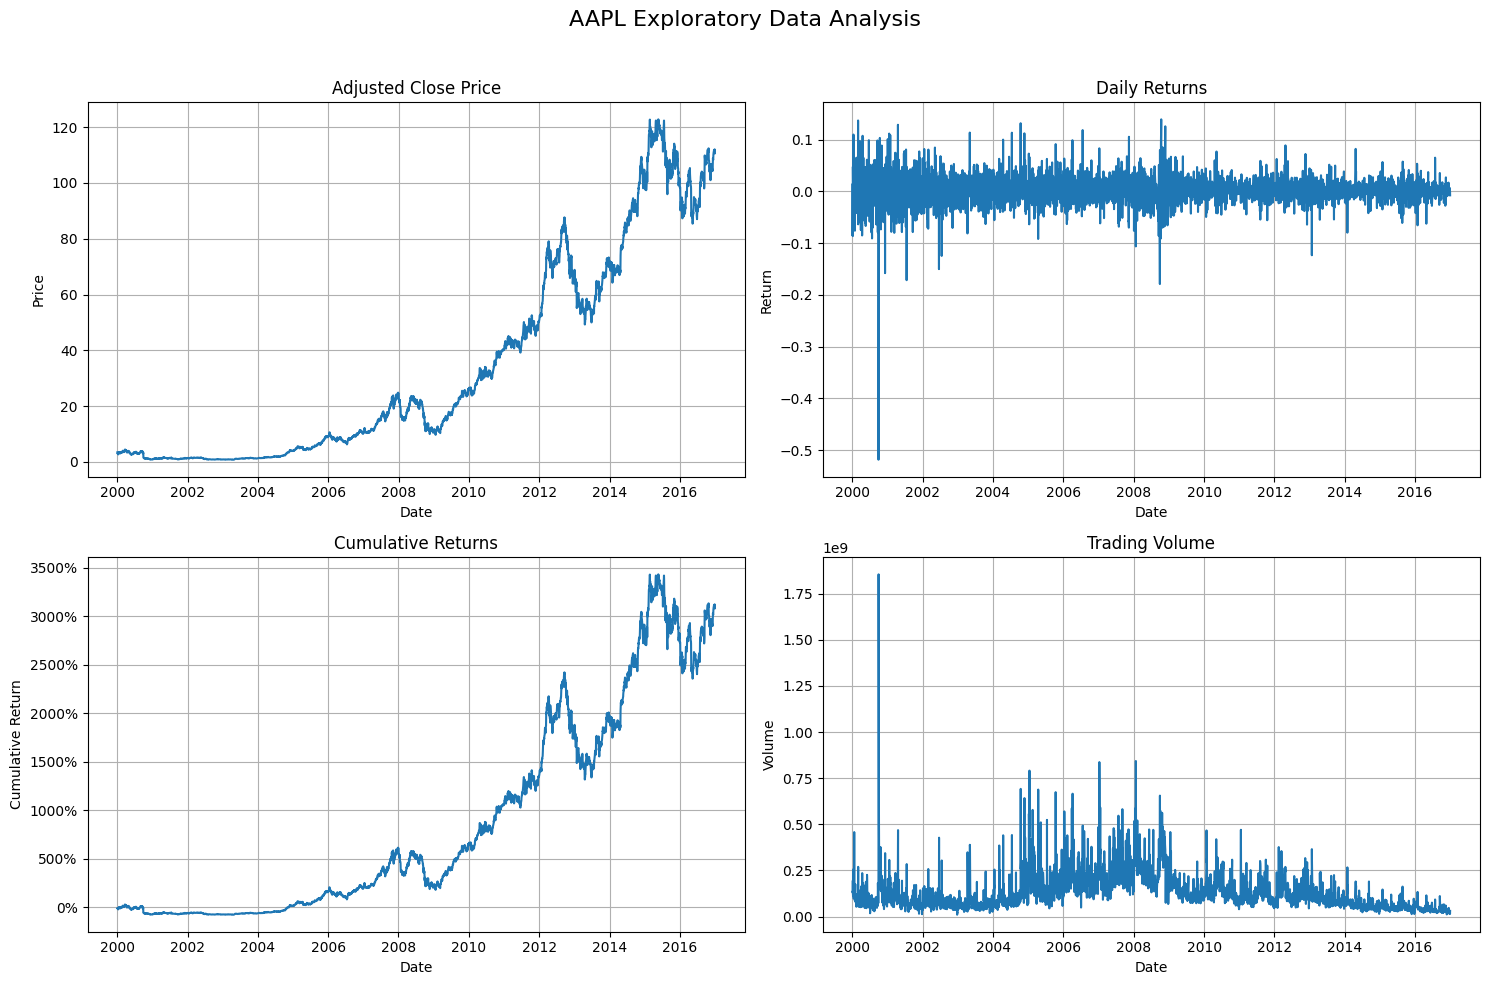


--- AAPL Return Statistics ---
count    4276.000000
mean        0.001186
std         0.026760
min        -0.518677
25%        -0.011262
50%         0.000806
75%         0.013808
max         0.139042
Name: Return, dtype: float64

Missing values per column:
Adj Close            0
Close                0
Div                  0
Factor               0
High                 0
Low                  0
Open                 0
Volume               0
Return               1
Cumulative_Return    1
dtype: int64

Date range:
Start date: 2000-01-03 00:00:00
End date: 2016-12-30 00:00:00

Data types:
Adj Close            float64
Close                float64
Div                  float64
Factor               float64
High                 float64
Low                  float64
Open                 float64
Volume               float64
Return               float64
Cumulative_Return    float64
dtype: object

Basic statistics:
         Adj Close        Close          Div       Factor         High  \
count  4277.000

In [77]:
data_dir = os.path.join(".", "Data", "train")
aapl = explore_ticker(data_dir, "AAPL")

Let's do some standardization and feature engineering

In [78]:
def standardize_rolling(series, window):
    rolling_mean = series.shift(1).rolling(window=window, min_periods=window).mean()
    rolling_std = series.shift(1).rolling(window=window, min_periods=window).std()
    
    standardized_series = (series - rolling_mean) / rolling_std
    
    return standardized_series

aapl_data = pd.read_csv(os.path.join(data_dir, "AAPL.csv"))

here I am using min_periods=window because I want to start from the standardized return series once I have full window for rolling average and standard deviation. 

In [79]:
def basic_features_standardized(df, window=30):
    price_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open']
    returns_df = pd.DataFrame(index=df.index)
    
    for col in price_cols:
        # Compute returns
        return_col = f"{col}_ret"
        returns_df[return_col] = df[col].pct_change()
        
        # Compute standardized returns
        std_col = f"{col}_ret_st"
        returns_df[std_col] = standardize_rolling(returns_df[return_col], window=window)

    # compute logarithm of volume
    returns_df["Volume_log"] = np.log(df["Volume"])

    return returns_df

returns_df = basic_features_standardized(aapl_data, window=30)

print(returns_df.head(10))

   Adj Close_ret  Adj Close_ret_st  Close_ret  Close_ret_st  High_ret  \
0            NaN               NaN        NaN           NaN       NaN   
1      -0.084318               NaN  -0.084315           NaN -0.016667   
2       0.014630               NaN   0.014634           NaN -0.000560   
3      -0.086546               NaN  -0.086538           NaN -0.032226   
4       0.047390               NaN   0.047368           NaN -0.056075   
5      -0.017594               NaN  -0.017588           NaN  0.012376   
6      -0.051159               NaN  -0.051151           NaN -0.028117   
7      -0.059954               NaN  -0.059968           NaN -0.038982   
8       0.109655               NaN   0.109671           NaN  0.034018   
9       0.038117               NaN   0.038119           NaN  0.035443   

   High_ret_st   Low_ret  Low_ret_st  Open_ret  Open_ret_st  Volume_log  
0          NaN       NaN         NaN       NaN          NaN   18.712971  
1          NaN -0.004917         NaN  0.032181  

#### Now let's start feature engineering (I am not going to use these features in the beginning, I will just add them later in more complex models). I am using pretty much all of important technical indicators, such as simple moving averages (SMA) and exponential moving averages (EMA) to capture trends over different periods. I’m also adding RSI, which shows if the stock is overbought or oversold, and MACD, which looks at momentum by comparing two EMAs.

#### I included Bollinger Bands to measure volatility (how much price moves around the average) and rolling volatility separately to just capture the return variability. I’m also adding the stochastic oscillator, which looks at where the close price is compared to the recent high and low, and ATR, which measures how much the stock usually moves day-to-day.

#### All of these are built using only past data up to day (t-1), so there’s no future leak. Altogether they should give a good mix of trend, momentum, and volatility signals for the model.

In [80]:
def calculate_sma(series, window):
    return series.rolling(window=window, min_periods=1).mean()

def calculate_ema(series, window):
    return series.ewm(span=window, adjust=False).mean()

def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window, min_periods=1).mean()
    std = series.rolling(window=window, min_periods=1).std()
    
    upper_band = sma + (num_std * std)
    lower_band = sma - (num_std * std)
    
    return upper_band, lower_band

def calculate_macd(series, fast=12, slow=26, signal=9):
    ema_fast = calculate_ema(series, window=fast)
    ema_slow = calculate_ema(series, window=slow)
    macd_line = ema_fast - ema_slow
    signal_line = calculate_ema(macd_line, window=signal)
    
    return macd_line, signal_line

def calculate_stochastic_oscillator(df, k_window=14, d_window=3):
    low_min = df['Low'].rolling(window=k_window, min_periods=1).min()
    high_max = df['High'].rolling(window=k_window, min_periods=1).max()
    
    percent_k = 100 * (df['Adj Close'] - low_min) / (high_max - low_min)
    percent_d = percent_k.rolling(window=d_window, min_periods=1).mean()
    
    return percent_k, percent_d

def calculate_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Adj Close'].shift())
    low_close = np.abs(df['Low'] - df['Adj Close'].shift())
    
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window, min_periods=1).mean()
    
    return atr

In [81]:
# Use Adj Close for most indicators
price_series = aapl_data['Adj Close']

full_df = returns_df

# Moving Averages
for window in [5, 10, 20, 50]:
    full_df[f'SMA_{window}'] = calculate_sma(price_series, window)
    full_df[f'EMA_{window}'] = calculate_ema(price_series, window)

# MACD
full_df['MACD_Line'], full_df['MACD_Signal'] = calculate_macd(price_series)

# RSI
full_df['RSI_14'] = calculate_rsi(price_series, window=14)

# Bollinger Bands
full_df['Bollinger_Upper'], full_df['Bollinger_Lower'] = calculate_bollinger_bands(price_series, window=20)

# Stochastic Oscillator
full_df['Stoch_%K'], full_df['Stoch_%D'] = calculate_stochastic_oscillator(aapl_data, k_window=14, d_window=3)

# ATR
full_df['ATR_14'] = calculate_atr(aapl_data, window=14)

full_df

,Adj Close_ret,Adj Close_ret_st,Close_ret,Close_ret_st,High_ret,High_ret_st,Low_ret,Low_ret_st,Open_ret,Open_ret_st,...,SMA_50,EMA_50,MACD_Line,MACD_Signal,RSI_14,Bollinger_Upper,Bollinger_Lower,Stoch_%K,Stoch_%D,ATR_14
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.478500,3.478500,0.000000,0.000000,NaN,NaN,NaN,-908.337958,-908.337958,10.812000
1,-0.084318,NaN,-0.084315,NaN,-0.016667,NaN,-0.004917,NaN,0.032181,NaN,...,3.331850,3.466998,-0.023397,-0.004679,0.000000,3.746639,2.917061,-866.361386,-887.349672,58.979250
2,0.014630,NaN,0.014634,NaN,-0.000560,NaN,0.017907,NaN,-0.041570,NaN,...,3.298500,3.457775,-0.037744,-0.011292,13.709915,3.613733,2.983267,-865.949434,-880.216259,75.112100
3,-0.086546,NaN,-0.086538,NaN,-0.032226,NaN,-0.077670,NaN,0.022827,NaN,...,3.211900,3.437944,-0.070867,-0.023207,7.520981,3.643456,2.780344,-525.988000,-752.766273,82.276125
4,0.047390,NaN,0.047368,NaN,-0.056075,NaN,0.005263,NaN,-0.090638,NaN,...,3.187920,3.424378,-0.084850,-0.035536,24.555629,3.576740,2.799100,-525.188571,-639.042002,85.430480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.001978,0.028842,0.001978,0.028851,0.000133,-0.160029,-0.000432,-0.258672,-0.006532,-0.740664,...,107.679352,107.570789,1.452375,1.075025,86.146147,113.772329,102.884321,25.747002,31.684316,6.234743
4273,0.006351,0.376098,0.006351,0.376096,0.010938,1.047408,0.007786,0.491965,0.008046,0.581273,...,107.683762,107.745040,1.495308,1.159081,86.009695,114.216317,102.983873,33.034722,29.819494,6.260564
4274,-0.004264,-0.702507,-0.004264,-0.702547,0.001842,-0.101964,-0.002489,-0.564705,0.008582,0.629543,...,107.680140,107.893729,1.473805,1.222026,79.937431,114.522067,103.184413,12.627747,23.803157,6.249421
4275,-0.000257,-0.426360,-0.000257,-0.426316,-0.007690,-1.394873,0.001721,-0.234508,-0.009105,-1.316410,...,107.677466,108.035461,1.437873,1.265195,77.085358,114.716471,103.583229,-14.054670,10.535933,6.192686


# Feedforward fully connected NN

First I will try simple neural network, which simply takes adjusted close return series (standardized) and outputs the next day's return.

In [82]:
def create_sequences(series, window_size):
    """
    series: a 1D pandas Series with clean 0,1,2,3 indexing
    """
    X = []
    y = []
    
    for i in range(window_size, len(series)):
        X.append(series[i-window_size:i].values.reshape(-1, 1))
        y.append(series[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_1 (Dense)          │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

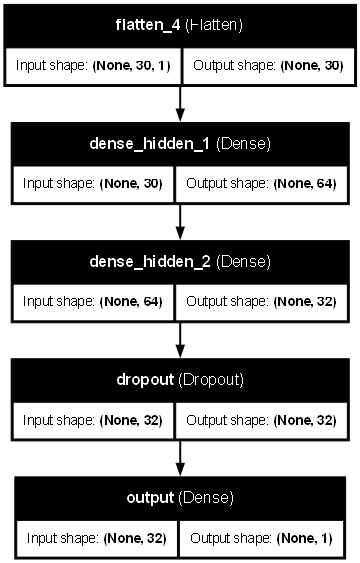

In [83]:
window_size = 30  # using past 30 days

# Create sequences
series = returns_df['Adj Close_ret_st'].dropna()
series = series.reset_index(drop=True)
X, y = create_sequences(series, window_size)

# Split into train and validation
split_idx = int(len(X) * 0.8)  # 80% train, 20% validation

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]  # Should be (30, 1)

# Create a Sequential model
model0 = Sequential([
    Flatten(input_shape=input_shape),  # Flatten the (30,1) input into (30,)
    Dense(64, activation='relu', name='dense_hidden_1'),  # First dense hidden layer
    Dense(32, activation='relu', name='dense_hidden_2'),  # Second dense hidden layer
    Dropout(0.5, name='dropout'),  # Dropout to prevent overfitting
    Dense(1, activation='linear', name='output')  # Output layer: one number (next day's return)
])

# Compile the model
model0.compile(optimizer='adam', loss='mse')

# Display the model summary
model0.summary()

# Plot the model structure (optional, but nice)
plot_model(model0, show_shapes=True, show_layer_names=True,dpi=70)

In [84]:
def plotTrainLoss(history):
    """
    Plots training and validation loss curves.
    Works for regression models (like yours).
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6016 - val_loss: 1.3377
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2363 - val_loss: 1.3215
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2129 - val_loss: 1.3202
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1967 - val_loss: 1.3175
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1270 - val_loss: 1.3158
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1923 - val_loss: 1.3217
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1807 - val_loss: 1.3227
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1814 - val_loss: 1.3237
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2655 - val_loss: 1.3281
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1164 - val_loss: 1.3229


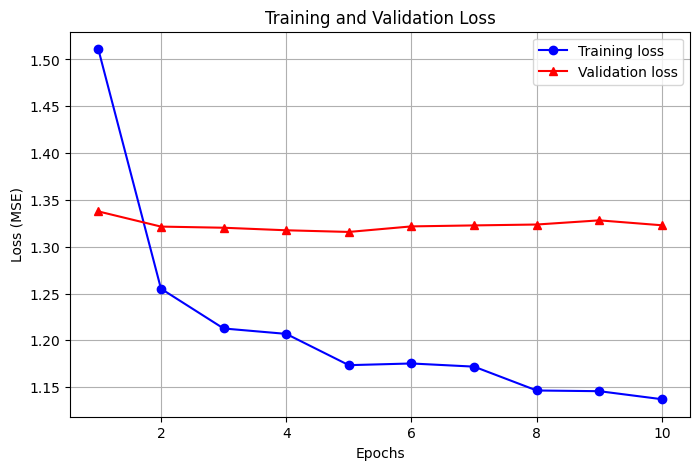

In [15]:
history0 = model0.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

plotTrainLoss(history0)

The loss is not exactly decreasing as we move through the epochs, so let's add more layers with more features. But to be honest I won't try focusing too much on this type of basic NNs because they are not that appropriate for time series data anyway.

In [16]:
model1 = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu', name='dense_hidden_1'),
    Dense(64, activation='relu', name='dense_hidden_2'),
    Dense(32, activation='relu', name='dense_hidden_3'),
    Dropout(0.3, name='dropout'),
    Dense(1, activation='linear', name='output')  # Output: next day's return
])

# Compile model with smaller learning rate
optimizer = Adam(learning_rate=0.0005)
model1.compile(optimizer=optimizer, loss='mse')

# Print model summary
model1.summary()

# Plot model diagram (optional, but nice)
plot_model(model1, show_shapes=True, dpi=70)

# Set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_1 (Dense)          │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 14,337 (56.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3483 - val_loss: 1.3352
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1680 - val_loss: 1.3310
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1616 - val_loss: 1.3282
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1313 - val_loss: 1.3459
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1268 - val_loss: 1.3410
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0750 - val_loss: 1.3496
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0652 - val_loss: 1.3606
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0058 - val_loss: 1.3725
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0094 - val_loss: 1.3986
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9427 - val_loss: 1.4114


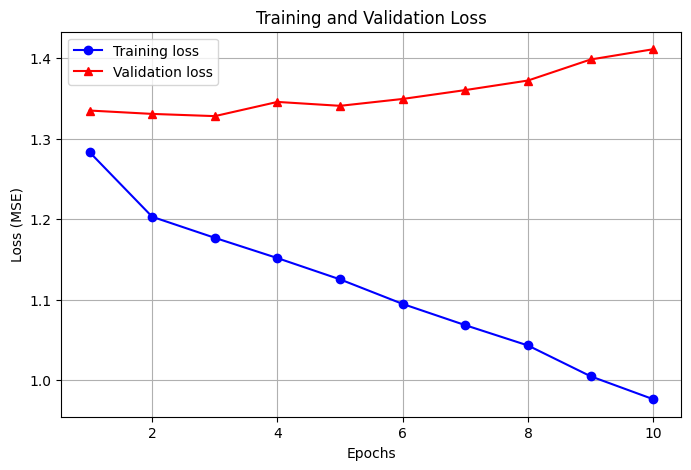

In [17]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,          # Train long, stop early if needed
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history1)

The model is not learning very well, the validation loss is not decreasing. There might be several reasons for it, the most important of which might be that the resurns data is noisy and does not inlucde any real signal, so I will add couple more features to the data and try to build a model based on that.

In [18]:
# Start from your original price dataframe (let's assume it's called aapl_data)

# Create df2 with required features
df2 = pd.DataFrame()

# Add standardized Adj Close returns
df2['Adj Close_ret_st'] = full_df['Adj Close_ret_st']

# Add RSI
df2['RSI_14'] = calculate_rsi(aapl_data['Adj Close'], window=14)

# Add MACD Line
df2['MACD_Line'], _ = calculate_macd(aapl_data['Adj Close'])

# Add SMA 10
df2['SMA_10'] = calculate_sma(aapl_data['Adj Close'], window=10)

# Add EMA 10
df2['EMA_10'] = calculate_ema(aapl_data['Adj Close'], window=10)

# Drop rows with any NaN values (early days where rolling indicators are not defined)
df2 = df2.dropna().reset_index(drop=True)

# Double check
print(df2.head())
print("\nShape of df2:", df2.shape)


   Adj Close_ret_st     RSI_14  MACD_Line   SMA_10    EMA_10
0         -0.893843  53.782108   0.075238  3.49301  3.495297
1          0.040112  64.133196   0.077218  3.52894  3.508825
2         -0.759101  57.753975   0.068907  3.53904  3.499420
3          0.375653  64.294437   0.067960  3.53826  3.506198
4          0.362700  68.002126   0.072490  3.54254  3.525526

Shape of df2: (4246, 5)


In [20]:
def create_multifeature_sequences(df, feature_columns, window_size):
    """
    Create sequences using multiple features.
    
    Args:
    - df: DataFrame containing features
    - feature_columns: list of columns to use
    - window_size: past window size (e.g., 30)
    
    Returns:
    - X: (samples, window_size, num_features)
    - y: (samples,)
    """
    X = []
    y = []
    features = df[feature_columns].dropna().reset_index(drop=True)
    target = df['Adj Close_ret_st'].dropna().reset_index(drop=True)  # target is still next day return

    for i in range(window_size, len(features)):
        X.append(features.iloc[i-window_size:i].values)  # (window_size, num_features)
        y.append(target.iloc[i])  # predict next day's standardized return

    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [49]:
# Pick features for input
feature_columns = [
    'Adj Close_ret_st',   # input feature too (standardized return)
    'RSI_14',
    'MACD_Line',
    'SMA_10',
    'EMA_10'
]

# Create sequences
X, y = create_multifeature_sequences(df2, feature_columns, window_size=30)

# Then train/test split
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Then build model2
input_shape = X_train.shape[1:]

model2 = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])
model2.compile(optimizer='adam', loss='mse')
model2.summary()


c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,697 (116.00 KB)

 Trainable params: 29,697 (116.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1911 - val_loss: 1.3098
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1954 - val_loss: 1.3617
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2041 - val_loss: 1.3033
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1713 - val_loss: 1.3128
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2385 - val_loss: 1.3057
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1507 - val_loss: 1.3112
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2981 - val_loss: 1.3119
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1439 - val_loss: 1.3130
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2325 - val_loss: 1.3148
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2026 - val_loss: 1.3004
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2550 - val_loss: 1.3105
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

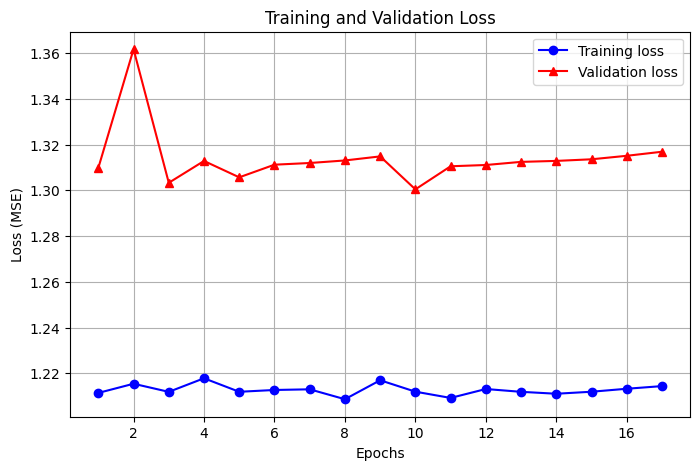

In [23]:
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,          # Train long, stop early if needed
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history2)

Alright, the loss is clearly not decreasing because this type of networks do not work well with sequential data because they do not "remember" what happened in the past, so let's move on to more appropriate models such as RNN, which is designed specifically for this type of task.

# RNN

Let's start with simple RNN

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

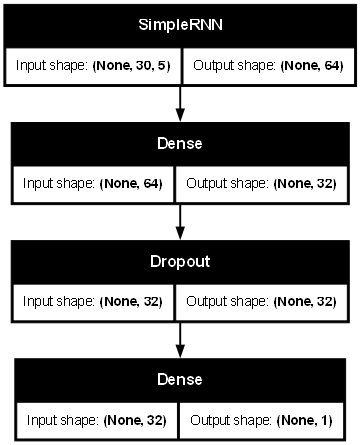

In [24]:
model3 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model3.compile(optimizer='adam', loss='mse')

# Model summary
model3.summary()

# Plot model
plot_model(model3, show_shapes=True, dpi=70)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8290 - val_loss: 1.2956
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2019 - val_loss: 1.3103
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4432 - val_loss: 1.4794
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2139 - val_loss: 1.3265
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1354 - val_loss: 1.3243
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1897 - val_loss: 1.3404
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1817 - val_loss: 1.3197
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1912 - val_loss: 1.2871
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2957 - val_loss: 1.3450
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1823 - val_loss: 1.2945
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2016 - val_loss: 1.3026
Epoch 12/100
106/106 ━━━━━━━━━━━━━━━━━━━━

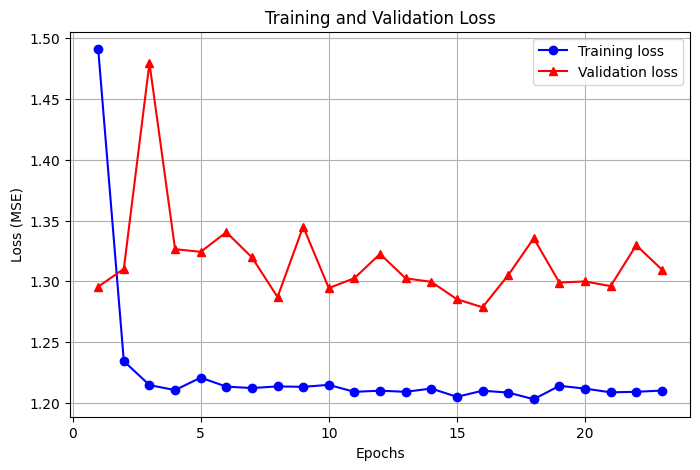

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history3)

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 64)         │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,673 (33.88 KB)

 Trainable params: 8,673 (33.88 KB)

 Non-trainable params: 0 (0.00 B)

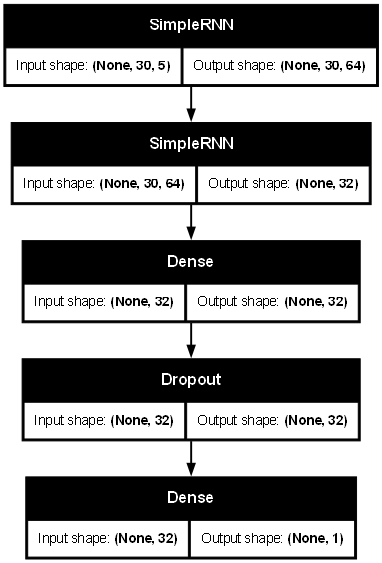

In [26]:
model4 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=input_shape, return_sequences=True),
    SimpleRNN(32, activation='tanh'),  # second RNN layer
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model4.compile(optimizer='adam', loss='mse')

# Model summary
model4.summary()

# Optional: Plot model structure
plot_model(model4, show_shapes=True, dpi=70)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.3963 - val_loss: 1.2979
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1856 - val_loss: 1.3287
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2161 - val_loss: 1.3009
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1918 - val_loss: 1.3555
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2693 - val_loss: 1.3056
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2000 - val_loss: 1.3163
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1435 - val_loss: 1.2998
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2820 - val_loss: 1.3030


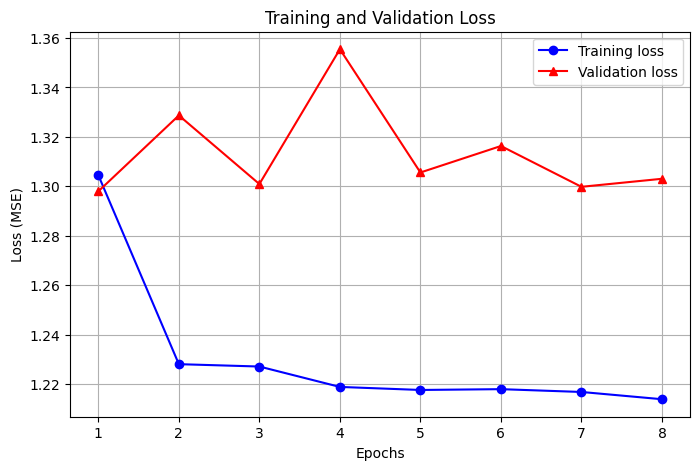

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history4)

Although the model is learning to some extent, the validation loss is not strictly decreasing over epochs, suggesting that the model is either not complex enough to capture meaningful patterns or is struggling due to the limited information in the input features. Therefore, further improvements are necessary to enhance the model’s ability to generalize. So below I will try to add some more features, make layers bigger, add batchnormalization, and lower learning rate.

In [ ]:
df2['SMA_20'] = calculate_sma(aapl_data['Adj Close'], window=20)
df2['EMA_20'] = calculate_ema(aapl_data['Adj Close'], window=20)
df2['Stoch_%K'], _ = calculate_stochastic_oscillator(aapl_data, k_window=14)
df2['ATR_14'] = calculate_atr(aapl_data, window=14)

feature_columns = [
    'Adj Close_ret_st',
    'RSI_14',
    'MACD_Line',
    'SMA_10',
    'EMA_10',
    'SMA_20',
    'EMA_20',
    'Stoch_%K',
    'ATR_14'
]

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 30, 128)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,753 (135.75 KB)

 Trainable params: 34,497 (134.75 KB)

 Non-trainable params: 256 (1.00 KB)

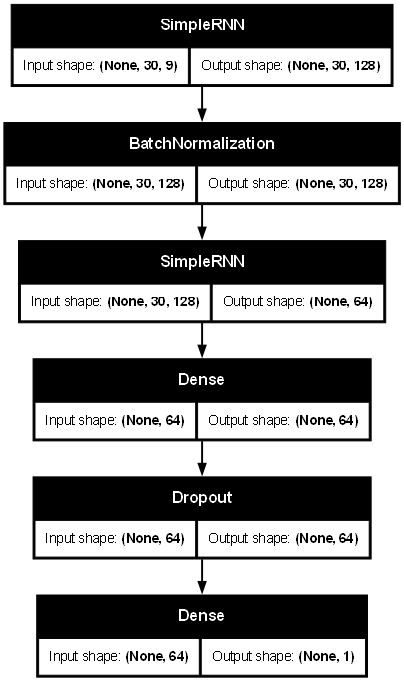

In [33]:
X, y = create_multifeature_sequences(df2, feature_columns, window_size=30)

# Then train/test split
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Then build model5
input_shape = X_train.shape[1:]

model5 = Sequential([
    SimpleRNN(128, activation='tanh', return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    SimpleRNN(64, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='linear')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=0.0003)
model5.compile(optimizer=optimizer, loss='mse')

# Summary
model5.summary()

# Optional plot
plot_model(model5, show_shapes=True, dpi=70)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3288 - val_loss: 1.4017
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2289 - val_loss: 1.5732
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1762 - val_loss: 1.7241
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2252 - val_loss: 1.8285
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2519 - val_loss: 1.9167
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1606 - val_loss: 1.9190
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1553 - val_loss: 1.8817
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1053 - val_loss: 1.8819


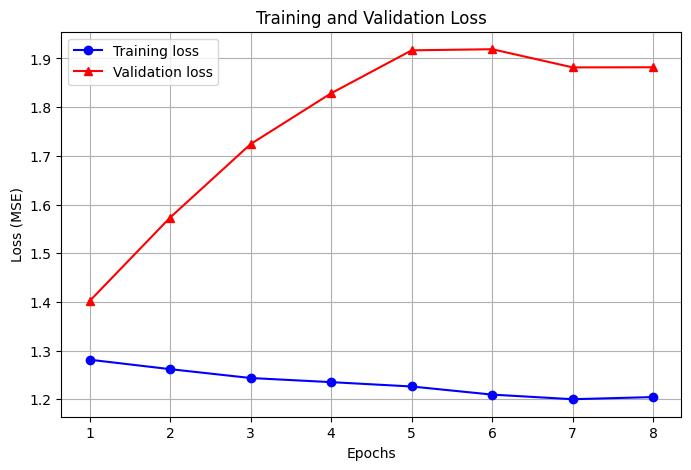

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history5 = model5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plotTrainLoss(history5)

Validation loss is actually increasing here even as training loss decreases, so experimenting with larger and deeper SimpleRNN models does not help apparently. I think I may have overcomplicated the model, making it too large relative to the amount and quality of information available. So the model was memorizing noise in the training set rather than learning patterns that generalize to new data. To address this, I will simplify the model architecture, add stronger regularization (higher dropout), lower the learning rate for more careful updates, and shift the task slightly: instead of predicting the exact next-day return, I will predict the direction (up or down). Predicting direction should be more stable and achievable, given the noisy nature of financial return data.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,849 (26.75 KB)

 Trainable params: 6,849 (26.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5111 - loss: 0.9463 - val_accuracy: 0.5296 - val_loss: 0.8738
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4911 - loss: 0.9454 - val_accuracy: 0.5320 - val_loss: 0.8583
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5151 - loss: 0.8290 - val_accuracy: 0.5249 - val_loss: 0.8513
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5070 - loss: 0.8456 - val_accuracy: 0.5249 - val_loss: 0.8340
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5074 - loss: 0.8068 - val_accuracy: 0.5332 - val_loss: 0.8274
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5131 - loss: 0.7734 - val_accuracy: 0.5344 - val_loss: 0.8227
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5106 - loss: 0.7634 - val_accuracy: 0.5379 - val_loss: 0.8194
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5090 - loss: 0.7699 - val_accuracy: 0.

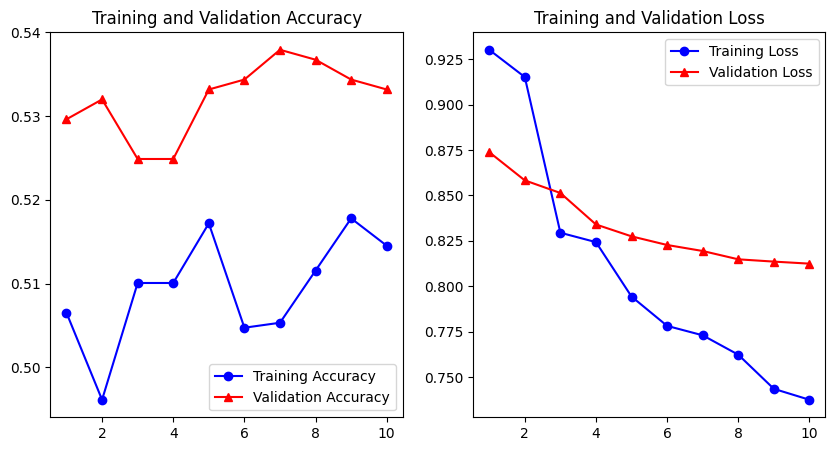

In [37]:
y_binary = (y > 0).astype(int)

# Split again for binary target
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y_binary[:split_idx], y_binary[split_idx:]

# Build model
input_shape = X_train.shape[1:]  # (30, 9)

model6 = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=input_shape),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # sigmoid for classification
])

optimizer = Adam(learning_rate=0.0001)
model6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model6.summary()

# Plot model
plot_model(model6, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history6 = model6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot
def plotTrain(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plotTrain(history6)

Well I simplified the model and used binary classification, which actually has decreasing losses on both training and validation part, but it actually does not perform better than random 50-50 classification (because accuracy is around 50%). So now I'll move on to LTSM.

# LSTM

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4997 - loss: 0.7008 - val_accuracy: 0.5213 - val_loss: 0.6914
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4927 - loss: 0.6975 - val_accuracy: 0.5071 - val_loss: 0.6929
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5099 - loss: 0.6955 - val_accuracy: 0.5344 - val_loss: 0.6910
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5118 - loss: 0.6939 - val_accuracy: 0.5415 - val_loss: 0.6920
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5137 - loss: 0.6949 - val_accuracy: 0.5225 - val_loss: 0.6915
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5396 - loss: 0.6888 - val_accuracy: 0.5047 - val_loss: 0.6921
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5086 - loss: 0.6942 - val_accuracy: 0.5154 - val_loss: 0.6931
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5178 - loss: 0.6927 - val_accu

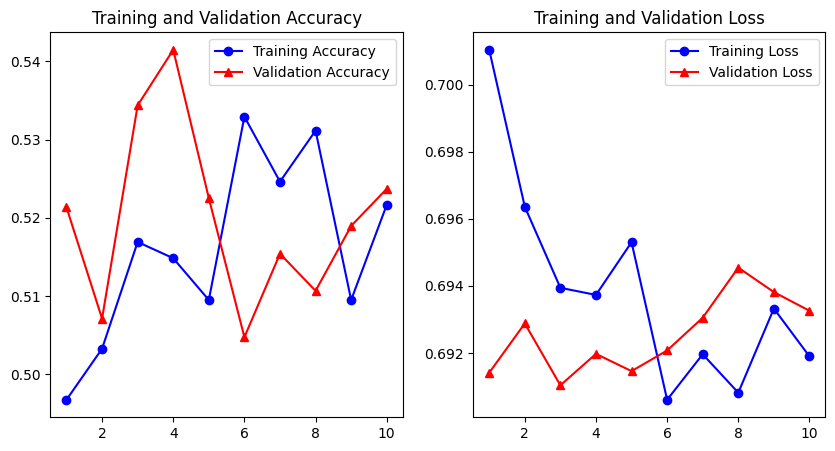

In [40]:
window_size = 30  # using past 30 days

# Create sequences
series = returns_df['Adj Close_ret_st'].dropna()
series = series.reset_index(drop=True)
X, y = create_sequences(series, window_size)

input_shape = X_train.shape[1:]  # (30, 9)

model7 = Sequential([
    LSTM(128, activation='tanh', input_shape=input_shape, return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation='tanh'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])

# Compile
optimizer = Adam(learning_rate=0.0003)  # Little faster learning rate since LSTM can stabilize better
model7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model7.summary()

# Plot
plot_model(model7, show_shapes=True, dpi=70)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train
history7 = model7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot
plotTrain(history7)

In [86]:
# 1. Rolling standardization function (so we don't peek into future)
def rolling_standardize(series, window=30):
    rolling_mean = series.shift(1).rolling(window=window, min_periods=1).mean()
    rolling_std = series.shift(1).rolling(window=window, min_periods=1).std()
    standardized = (series - rolling_mean) / rolling_std
    return standardized

# 2. Load external data
def load_adj_close_return(csv_path):
    df = pd.read_csv(csv_path, parse_dates=['Dt'])  # assuming 'Dt' column for dates
    df = df.set_index('Dt')
    df['Adj Close_return'] = df['Adj Close'].pct_change()
    return df['Adj Close_return']

# Paths to CSVs
spy_path = os.path.join(data_dir, "SPY.csv")
goog_path = os.path.join(data_dir, "GOOG.csv")
msft_path = os.path.join(data_dir, "MSFT.csv")

# Load returns
spy_ret = load_adj_close_return(spy_path)
goog_ret = load_adj_close_return(goog_path)
msft_ret = load_adj_close_return(msft_path)

# 3. Merge these returns into full_df
full_df = full_df.copy()

full_df['SPY_ret'] = spy_ret.values
full_df['GOOG_ret'] = goog_ret.values
full_df['MSFT_ret'] = msft_ret.values

# 4. Standardize newly added returns (rolling 30 days)
full_df['SPY_ret_st'] = rolling_standardize(full_df['SPY_ret'], window=30)
full_df['GOOG_ret_st'] = rolling_standardize(full_df['GOOG_ret'], window=30)
full_df['MSFT_ret_st'] = rolling_standardize(full_df['MSFT_ret'], window=30)

# Define list of columns to drop (raw returns that are not standardized)
drop_substrings = [
    '_ret',        # any column containing '_ret'
]
# But allow '_ret_st' to stay

feature_columns = []

for col in full_df.columns:
    # Keep if:
    # 1. It's a standardized return (ends with '_ret_st')
    # OR
    # 2. It does not contain '_ret' at all (technical indicators, prices, etc.)
    if col.endswith('_ret_st') or all(substr not in col for substr in drop_substrings):
        feature_columns.append(col)

print("Final feature columns being used:")
print(feature_columns)

print("\nShape of final full_df:", full_df.shape)


Final feature columns being used:
['Adj Close_ret_st', 'Close_ret_st', 'High_ret_st', 'Low_ret_st', 'Open_ret_st', 'Volume_log', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'MACD_Line', 'MACD_Signal', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower', 'Stoch_%K', 'Stoch_%D', 'ATR_14', 'SPY_ret_st', 'GOOG_ret_st', 'MSFT_ret_st']

Shape of final full_df: (4277, 33)


In [87]:
lstm_df = full_df[feature_columns]
lstm_df

,Adj Close_ret_st,Close_ret_st,High_ret_st,Low_ret_st,Open_ret_st,Volume_log,SMA_5,EMA_5,SMA_10,EMA_10,...,MACD_Signal,RSI_14,Bollinger_Upper,Bollinger_Lower,Stoch_%K,Stoch_%D,ATR_14,SPY_ret_st,GOOG_ret_st,MSFT_ret_st
0,NaN,NaN,NaN,NaN,NaN,18.712971,3.47850,3.478500,3.47850,3.478500,...,0.000000,NaN,NaN,NaN,-908.337958,-908.337958,10.812000,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,18.668278,3.33185,3.380733,3.33185,3.425173,...,-0.004679,0.000000,3.746639,2.917061,-866.361386,-887.349672,58.979250,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,19.086356,3.29850,3.331089,3.29850,3.390014,...,-0.011292,13.709915,3.613733,2.983267,-865.949434,-880.216259,75.112100,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,19.072971,3.21190,3.204759,3.21190,3.310393,...,-0.023207,7.520981,3.643456,2.780344,-525.988000,-752.766273,82.276125,0.089480,NaN,-0.698146
4,NaN,NaN,NaN,NaN,NaN,18.562038,3.18792,3.167173,3.18792,3.270685,...,-0.035536,24.555629,3.576740,2.799100,-525.188571,-639.042002,85.430480,3.700724,NaN,1.253647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.028842,0.028851,-0.160029,-0.258672,-0.740664,16.472232,111.47162,111.196223,110.70836,110.446019,...,1.075025,86.146147,113.772329,102.884321,25.747002,31.684316,6.234743,-0.022581,-0.161300,-0.582139
4273,0.376098,0.376096,1.047408,0.491965,0.581273,16.722242,111.59008,111.468882,111.08664,110.731143,...,1.159081,86.009695,114.216317,102.983873,33.034722,29.819494,6.260564,0.212652,0.073898,-0.194058
4274,-0.702507,-0.702547,-0.101964,-0.564705,0.629543,16.855542,111.55378,111.491455,111.23662,110.877590,...,1.222026,79.937431,114.522067,103.184413,12.627747,23.803157,6.249421,-2.256922,-0.890763,-0.653157
4275,-0.426360,-0.426316,-1.394873,-0.234508,-1.316410,16.526191,111.49072,111.496936,111.38373,110.992191,...,1.265195,77.085358,114.716471,103.583229,-14.054670,10.535933,6.192686,-0.337779,-0.497862,-0.415407


Also let's increase window size to 60

In [94]:
def updated_create_multifeature_sequences(df, feature_columns, window_size=60, target_col='Target'):
    X = []
    y = []
    
    features = df[feature_columns].values
    target = df[target_col].values  # ✅ use correct label column

    for i in range(window_size, len(df)):
        X.append(features[i-window_size:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)


In [95]:
# 1. Load original AAPL data
aapl_path = os.path.join(data_dir, "AAPL.csv")
aapl = pd.read_csv(aapl_path, parse_dates=["Dt"])
aapl = aapl.set_index('Dt')

# 2. Make sure full_df has the right index for merging
# (If full_df does not have 'Dt' index, just align by row number — safest way for now)
aapl = aapl.reset_index(drop=True)

# 4. Now you can create the Target correctly
lstm_df['Target'] = (aapl['Adj Close'].shift(-1) > aapl['Adj Close']).astype(int)

window_size = 60
X, y = updated_create_multifeature_sequences(lstm_df, feature_columns, window_size)

split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

input_shape = X_train.shape[1:]  # (60, 24)
input_shape

C:\Users\gigan\AppData\Local\Temp\ipykernel_72256\1496591091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_df['Target'] = (aapl['Adj Close'].shift(-1) > aapl['Adj Close']).astype(int)


(60, 25)

c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,249 (520.50 KB)

 Trainable params: 132,865 (519.00 KB)

 Non-trainable params: 384 (1.50 KB)

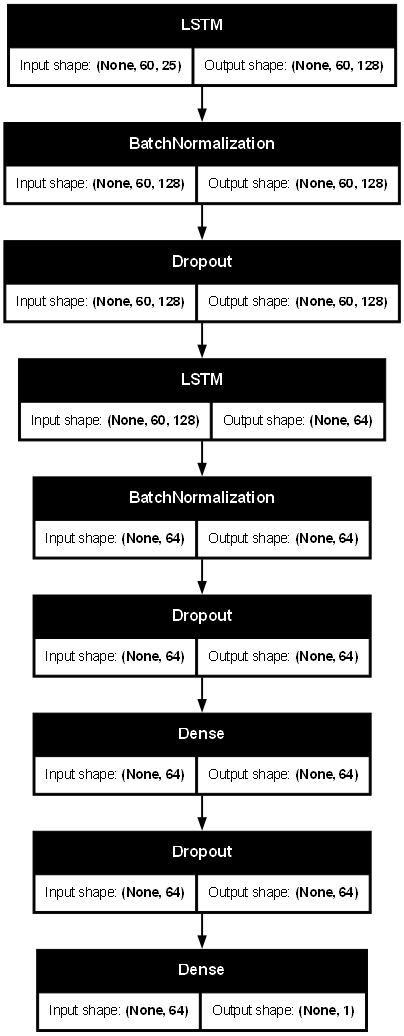

In [96]:
model7 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile model
optimizer = Adam(learning_rate=0.0003)
model7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model7.summary()

# Optional plot
plot_model(model7, show_shapes=True, dpi=70)

In [97]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train the model
history7 = model7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=early_stop,
    verbose=1
)


Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 88ms/step - accuracy: 0.5039 - loss: 0.6931 - val_accuracy: 0.5166 - val_loss: 0.6931
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.5129 - loss: 0.6931 - val_accuracy: 0.5166 - val_loss: 0.6930
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5100 - loss: 0.6931 - val_accuracy: 0.5166 - val_loss: 0.6929
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5235 - loss: 0.6928 - val_accuracy: 0.5166 - val_loss: 0.6929
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.5230 - loss: 0.6928 - val_accuracy: 0.5166 - val_loss: 0.6929
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4955 - loss: 0.6933 - val_accuracy: 0.5166 - val_loss: 0.6928
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.5186 - loss: 0.6928 - val_accuracy: 0.5166 - val_loss: 0.6928
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.5091 - loss: 0.6930 - val_acc

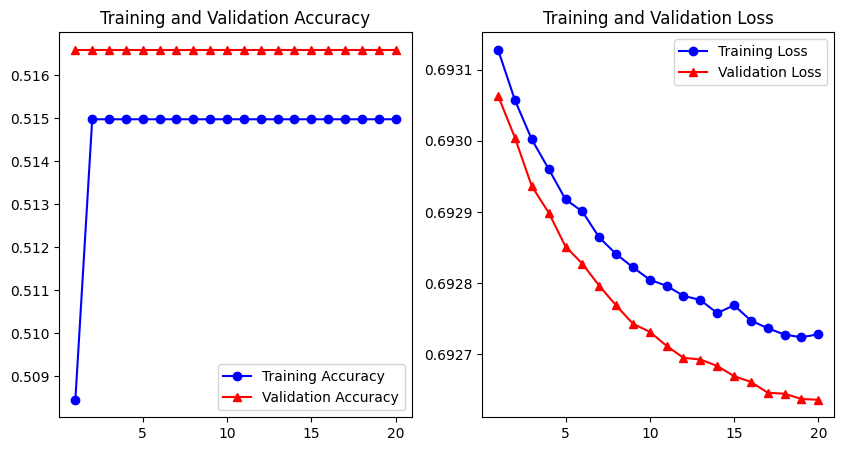

In [98]:
plotTrain(history7)

The model still is performing poorly, because I mean 50% accuracy is as good as random guessing of 0s or 1s. So below I check for this and it turns out I am right the model is actually always guessing 1s.

In [99]:
pred_probs = model7.predict(X_val)
pred_labels = (pred_probs > 0.5).astype(int)

print("Distribution of predictions:", np.unique(pred_labels, return_counts=True))
print("Distribution of true labels:", np.unique(y_val, return_counts=True))


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Distribution of predictions: (array([1]), array([844]))
Distribution of true labels: (array([0, 1]), array([408, 436]))


In [100]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model_final.predict(X_val) > 0.5).astype(int)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
[[  0 408]
 [  0 436]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       408
           1       0.52      1.00      0.68       436

    accuracy                           0.52       844
   macro avg       0.26      0.50      0.34       844
weighted avg       0.27      0.52      0.35       844



c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [101]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0308679706601467), 1: np.float64(0.9709268854346574)}


In [104]:
input_shape = X_train.shape[1:]  # should now be (60, 25)

model8 = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(64, activation='tanh'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # For binary classification
])

model8.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5146 - loss: 0.6929 - val_accuracy: 0.5166 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5186 - loss: 0.6930 - val_accuracy: 0.5166 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4943 - loss: 0.6932 - val_accuracy: 0.4834 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.4928 - loss: 0.6934 - val_accuracy: 0.5166 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5028 - loss: 0.6934 - val_accuracy: 0.5166 - val_loss: 0.6931 - learning_rate: 3.0000e-04
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4797 - loss: 0.6937
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy

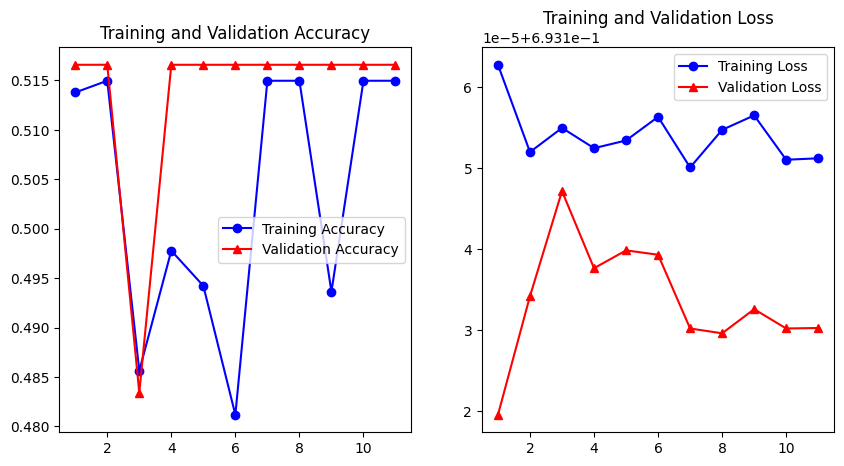

In [105]:
history8 = model8.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plotTrain(history8)


In [107]:
pip install xgboost

     ------------------------------------- 150.0/150.0 MB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [108]:
# 1. Build the CNN-LSTM-Attention feature extractor
def build_cnn_lstm_attention(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=True)(x)
    
    # Self-attention layer
    attention = Attention()([x, x])
    x = LayerNormalization()(attention)
    x = Flatten()(x)
    
    model = Model(inputs, x)
    return model

# 2. Extract features
input_shape = X.shape[1:]  # (60, 25)
feature_extractor = build_cnn_lstm_attention(input_shape)

X_features = feature_extractor.predict(X, verbose=1)

# 3. Train/test split
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_features, y, test_size=0.2, random_state=42)

# 4. XGBoost classification
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_f, y_train_f)

# 5. Evaluate
y_pred = xgb_model.predict(X_val_f)
print(classification_report(y_val_f, y_pred))


132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


c:\Users\gigan\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:16:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.51      0.67      0.58       415
           1       0.54      0.38      0.44       429

    accuracy                           0.52       844
   macro avg       0.52      0.52      0.51       844
weighted avg       0.52      0.52      0.51       844

